## QAOA - qiskit library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit import IBMQ
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer, WarmStartRecursiveMinimumEigenOptimizer, WarmStartQAOAOptimizer
from qiskit_ibm_runtime import QiskitRuntimeService
import networkx as nx
import random

In [2]:
IBMQ.save_account('', overwrite = True)
provider = IBMQ.load_account()

In [3]:
QiskitRuntimeService.save_account(channel="", token='', overwrite=True)
service = QiskitRuntimeService()

# PROGRAM UPDATES

In [69]:
# data = os.path.join(
#     os.getcwd(), "remote/qaoa.py"
# )
# meta = os.path.join(
#     os.getcwd(), "remote/qaoa_metadata.json"
# )
#
# service.update_program(program_id = "", data=data, metadata=meta)

In [4]:
iterations = 0
energy_mean = []
energy_sd = []

def evaluate_QAOA(qp = None, optimizer = None, backend = None, provider = None, recursive = False, warm_start = False, 
                  pre_solver = None, relax_for_pre_solver = False):
    global iterations, energy_mean, energy_sd
    energy_mean = []
    energy_sd = []
    qaoa_mes = QAOA(optimizer = optimizer, quantum_instance = backend, callback = evaluation_callback)
    if warm_start and recursive:
        qaoa = WarmStartRecursiveMinimumEigenOptimizer(qaoa=qaoa_mes, pre_solver=pre_solver, relax_for_pre_solver=relax_for_pre_solver)
    elif warm_start:
        qaoa = WarmStartQAOAOptimizer(qaoa=qaoa_mes, pre_solver=pre_solver, relax_for_pre_solver=relax_for_pre_solver)
    elif recursive:
        qaoa = RecursiveMinimumEigenOptimizer(qaoa_mes)
    else:
        qaoa = MinimumEigenOptimizer(qaoa_mes)
    qaoa_result = qaoa.solve(qp)
    print('\033[1m' + "Number of iterations: "+ str(len(energy_mean)) + '\033[0m')
    samples_to_bar_charts(qaoa_result.samples)
    plot_energy_chart(iterations, energy_mean, energy_sd)

In [5]:
def samples_to_bar_charts(samples):
    labels = []
    probabilities = []
    fvals = []
    for s in samples:
        labels.append(("".join([str(int(_)) for _ in s["x"]])))
        probabilities.append(s["probability"])
        fvals.append(s["fval"])
    
    plt.figure(figsize=(18, 8))
    
    idx   = np.argsort(probabilities)

    probabilities_top = np.array(probabilities)[idx]
    labels_top = np.array(labels)[idx]
    
    probabilities_top = probabilities_top[0:31]
    labels_top = labels_top[0:31]
    
    y_pos = np.arange(len(labels_top))
    plt.subplot(1, 2, 1)
    plt.barh(y_pos, probabilities_top, align='center', color = (0.3,0.4,0.8))
    plt.yticks(y_pos, labels_top)
    plt.xlabel('Probability')
    plt.ylabel('Basis state')
    plt.title('Sampling probabilities for computational basis state of the circuit (top 30)')
    
    fvals_probabilities = []
    fvals_labels = []
    
    for idx, probability in enumerate(probabilities):
        fval = fvals[idx]
        if fval in fvals_labels:
            idx_2 = fvals_labels.index(fval)
            fvals_probabilities[idx_2] += probability
        else:
            fvals_labels.append(fval)
            fvals_probabilities.append(probability)
    
    y_pos = np.arange(len(fvals_labels))
    plt.subplot(1, 2, 2)
    plt.bar(y_pos, fvals_probabilities, align='center', alpha=0.5, color = (0.6,0,0.6))
    plt.xticks(y_pos, fvals_labels)
    plt.ylabel('Probability')
    plt.xlabel('Objective function value')
    plt.title('Sampling probabilities for computational basis state with objective function value')

    plt.show()

def plot_energy_chart(iterations, energy_mean, energy_sd):
    plt.figure(figsize=(18, 8))
    x = list(range(1, len(energy_mean) + 1))
    plt.errorbar(x, energy_mean, energy_sd, linestyle='-', marker='o', ecolor='red', markeredgecolor = 'blue', markerfacecolor = 'blue', color = 'blue')
    plt.ylabel('Energy')
    plt.xlabel('Iteration')
    plt.title('Energy measured on the hardware at each iteration')
    plt.show()
    
def show_result(job_result):
    samples_to_bar_charts(job_result["samples"])
    plot_energy_chart(iterations = len(job_result["optimizer_history"]["nfevs"]), energy_mean = job_result["optimizer_history"]["energy"], energy_sd = job_result["optimizer_history"]["std"])

### Problem definition - MaxCut


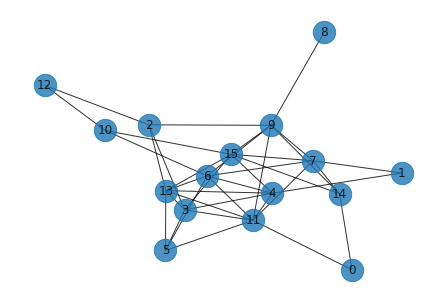

In [6]:
G = nx.Graph()

N = 15
dagree = 7

nodes = list(range(0, N+1))

edges = []
for i in range(0,N+1):
    number_of_vertices = random.randint(0,dagree)
    for k in range(0, number_of_vertices):
        j = random.randint(0,N)
        while j == i:
            j = random.randint(0,N)
        if (i, j) not in edges and (j,i) not in edges:
            edges.append((i,j))
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [7]:
max_cut = Maxcut(G)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_11 - 2*x_0*x_14 - 2*x_1*x_4 - 2*x_1*x_7 - 2*x_10*x_12 - 2*x_10*x_15
  - 2*x_11*x_13 - 2*x_13*x_15 - 2*x_14*x_15 - 2*x_2*x_12 - 2*x_2*x_13
  - 2*x_2*x_3 - 2*x_2*x_9 - 2*x_3*x_11 - 2*x_3*x_13 - 2*x_3*x_15 - 2*x_3*x_4
  - 2*x_3*x_5 - 2*x_4*x_11 - 2*x_4*x_13 - 2*x_4*x_15 - 2*x_4*x_6 - 2*x_5*x_11
  - 2*x_5*x_13 - 2*x_5*x_6 - 2*x_6*x_10 - 2*x_6*x_11 - 2*x_6*x_13 - 2*x_6*x_7
  - 2*x_6*x_9 - 2*x_7*x_11 - 2*x_7*x_14 - 2*x_7*x_15 - 2*x_7*x_9 - 2*x_8*x_9
  - 2*x_9*x_11 - 2*x_9*x_14 - 2*x_9*x_15 + 2*x_0 + 2*x_1 + 3*x_10 + 8*x_11
  + 2*x_12 + 7*x_13 + 4*x_14 + 7*x_15 + 4*x_2 + 6*x_3 + 6*x_4 + 4*x_5 + 7*x_6
  + 6*x_7 + x_8 + 7*x_9

Subject to
  No constraints

  Binary variables (16)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9 x_10 x_11 x_12 x_13 x_14 x_15



In [8]:
qubit_op, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubit_op))

Offset: -19.0
Ising Hamiltonian:
0.5 * IIIIIIIIIIIIZZII
+ 0.5 * IIIIIIIIIIIZIIZI
+ 0.5 * IIIIIIIIIIIZZIII
+ 0.5 * IIIIIIIIIIZIZIII
+ 0.5 * IIIIIIIIIZIZIIII
+ 0.5 * IIIIIIIIIZZIIIII
+ 0.5 * IIIIIIIIZIIIIIZI
+ 0.5 * IIIIIIIIZZIIIIII
+ 0.5 * IIIIIIZIIIIIIZII
+ 0.5 * IIIIIIZIIZIIIIII
+ 0.5 * IIIIIIZIZIIIIIII
+ 0.5 * IIIIIIZZIIIIIIII
+ 0.5 * IIIIIZIIIZIIIIII
+ 0.5 * IIIIZIIIIIIIIIIZ
+ 0.5 * IIIIZIIIIIIIZIII
+ 0.5 * IIIIZIIIIIIZIIII
+ 0.5 * IIIIZIIIIIZIIIII
+ 0.5 * IIIIZIIIIZIIIIII
+ 0.5 * IIIIZIIIZIIIIIII
+ 0.5 * IIIIZIZIIIIIIIII
+ 0.5 * IIIZIIIIIIIIIZII
+ 0.5 * IIIZIZIIIIIIIIII
+ 0.5 * IIZIIIIIIIIIIZII
+ 0.5 * IIZIIIIIIIIIZIII
+ 0.5 * IIZIIIIIIIIZIIII
+ 0.5 * IIZIIIIIIIZIIIII
+ 0.5 * IIZIIIIIIZIIIIII
+ 0.5 * IIZIZIIIIIIIIIII
+ 0.5 * IZIIIIIIIIIIIIIZ
+ 0.5 * IZIIIIIIZIIIIIII
+ 0.5 * IZIIIIZIIIIIIIII
+ 0.5 * ZIIIIIIIIIIIZIII
+ 0.5 * ZIIIIIIIIIIZIIII
+ 0.5 * ZIIIIIIIZIIIIIII
+ 0.5 * ZIIIIIZIIIIIIIII
+ 0.5 * ZIIIIZIIIIIIIIII
+ 0.5 * ZIZIIIIIIIIIIIII
+ 0.5 * ZZIIIIIIIIIIIIII


### Exact solution:

In [9]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 29.0
variable values: x_0=0.0, x_1=1.0, x_2=1.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=1.0, x_7=0.0, x_8=1.0, x_9=0.0, x_10=0.0, x_11=1.0, x_12=0.0, x_13=0.0, x_14=1.0, x_15=1.0
status: SUCCESS


In [10]:
optimizer = COBYLA()

# IBMQ Qasm Simulator

## QAOA

In [11]:
options = {"backend_name": "ibmq_qasm_simulator"}
runtime_inputs = {
    "operator": qubit_op,
    "offset": offset,
    "optimizer": optimizer,
}

job = provider.runtime.run(program_id="qaoa-RQ8n60B9Xb", options=options, inputs=runtime_inputs)

In [12]:
result = job.result()

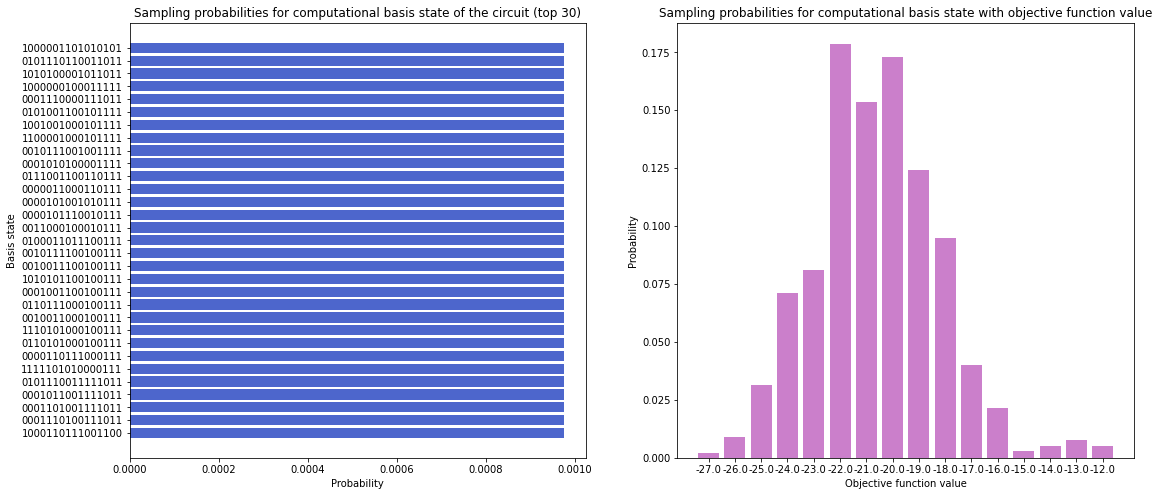

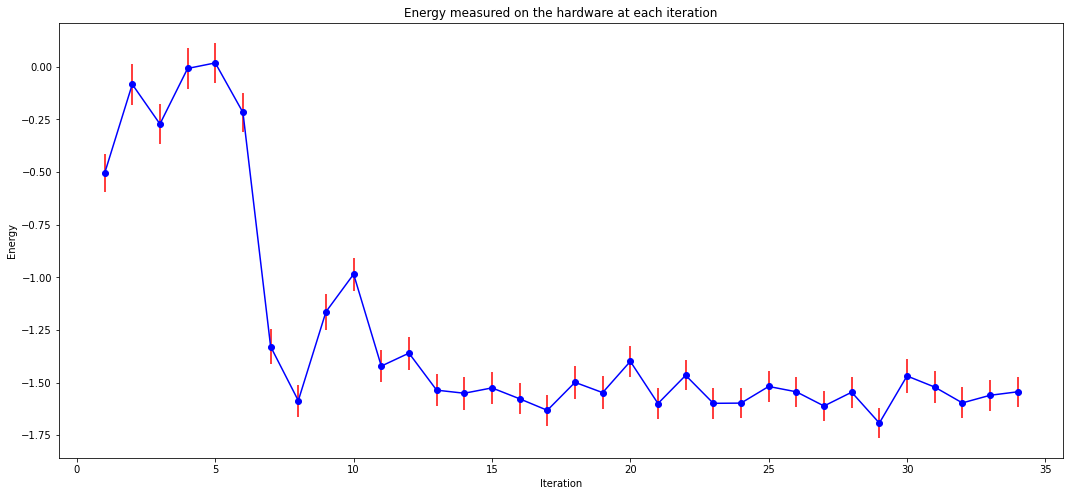

In [13]:
show_result(job_result=result)

## WS-QAOA

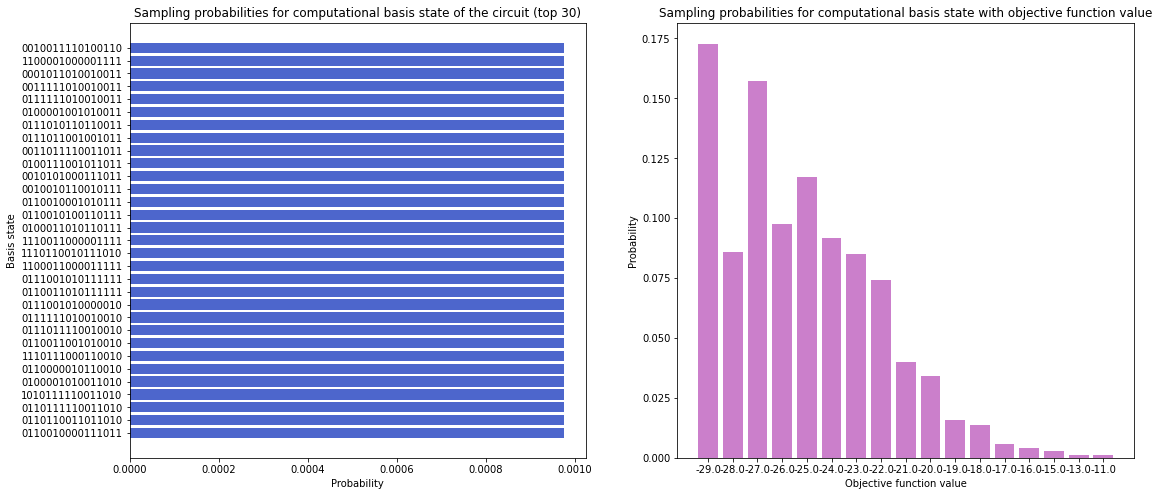

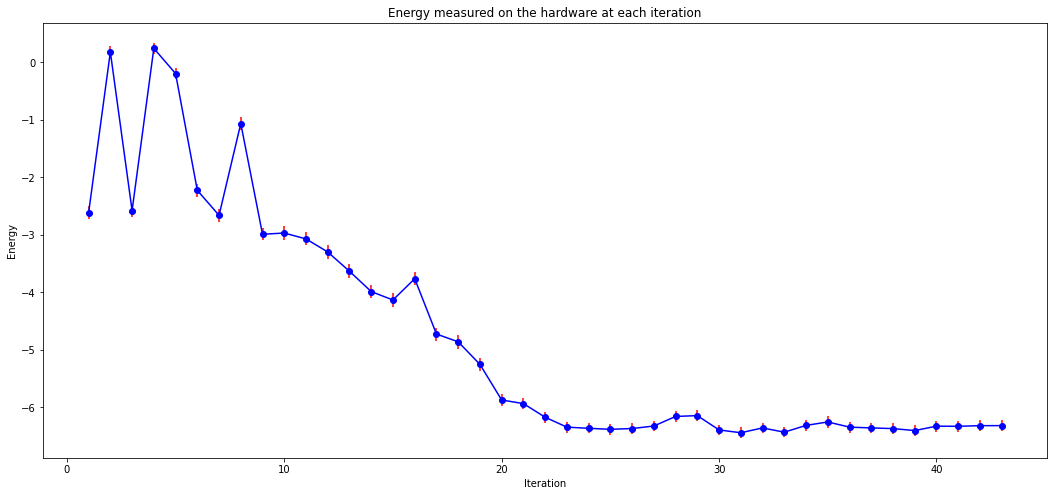

In [17]:
options = {"backend_name": "ibmq_qasm_simulator"}
runtime_inputs = {
    "operator": qubit_op,
    "offset": offset,
    "warm_start": True,
    "optimizer": optimizer
}

job = provider.runtime.run(program_id="qaoa-RQ8n60B9Xb", options=options, inputs=runtime_inputs)

show_result(job_result=job.result())

## R-QAOA

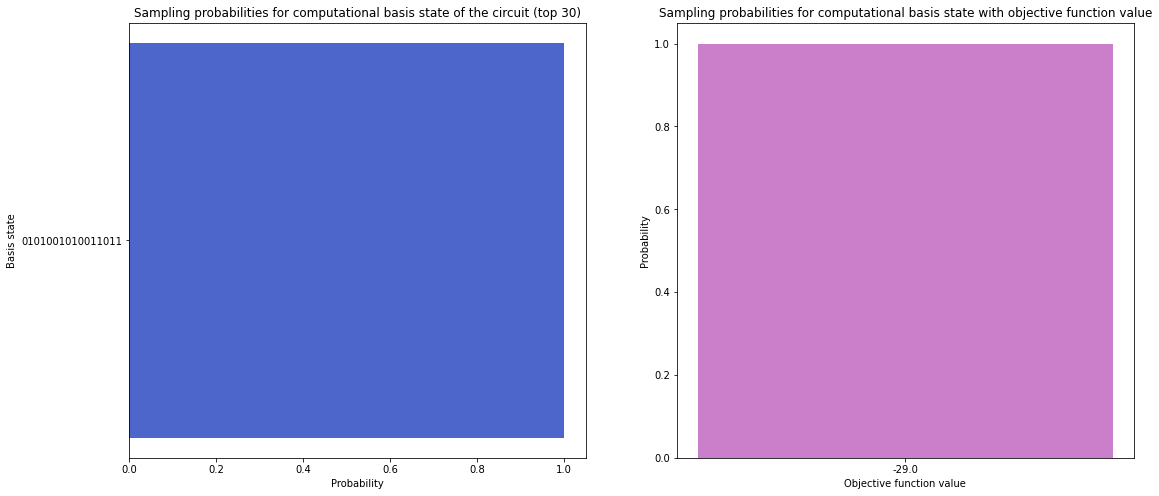

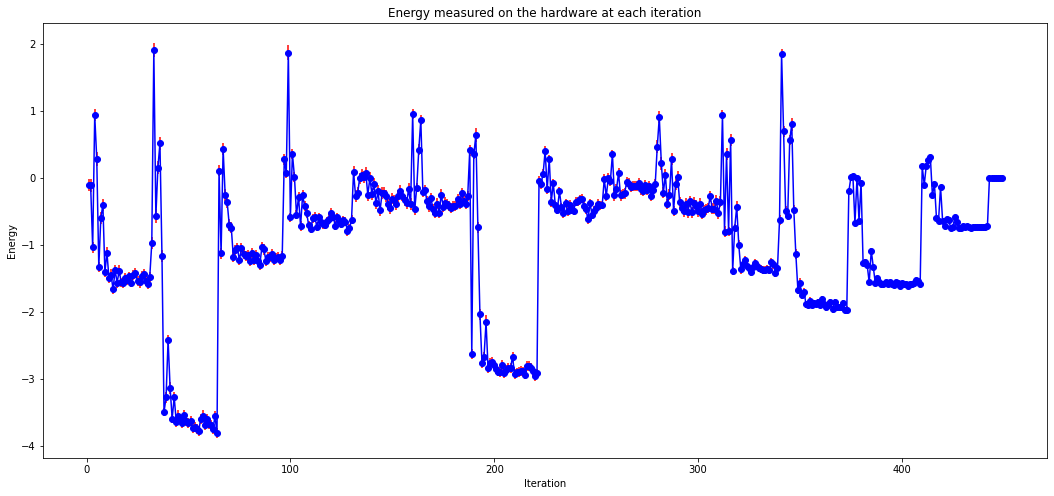

In [15]:
options = {"backend_name": "ibmq_qasm_simulator"}
runtime_inputs = {
    "operator": qubit_op,
    "offset": offset,
    "recursive": True,
    "optimizer": optimizer
}

job = provider.runtime.run(program_id="qaoa-RQ8n60B9Xb", options=options, inputs=runtime_inputs)

show_result(job_result=job.result())

## WS-R-QAOA

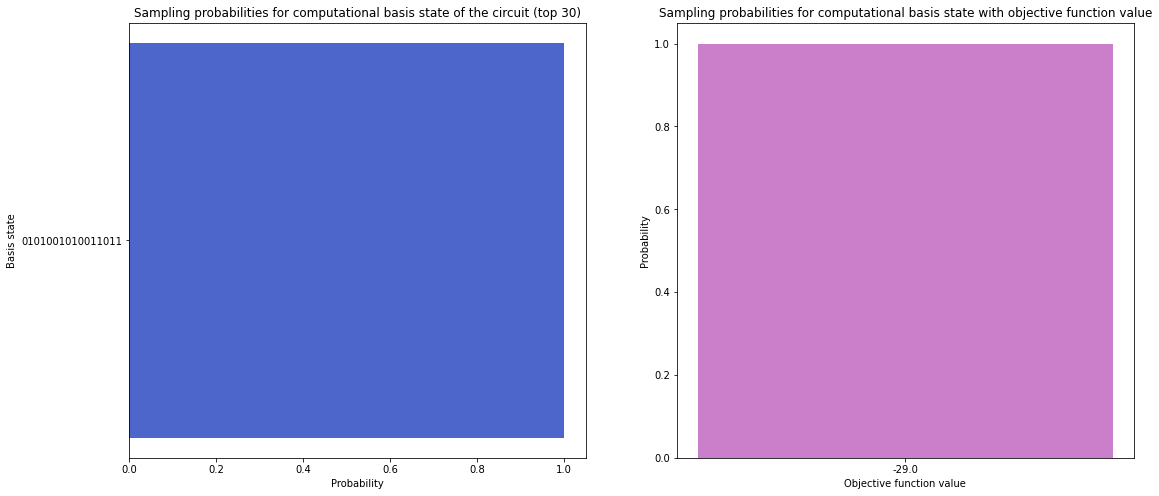

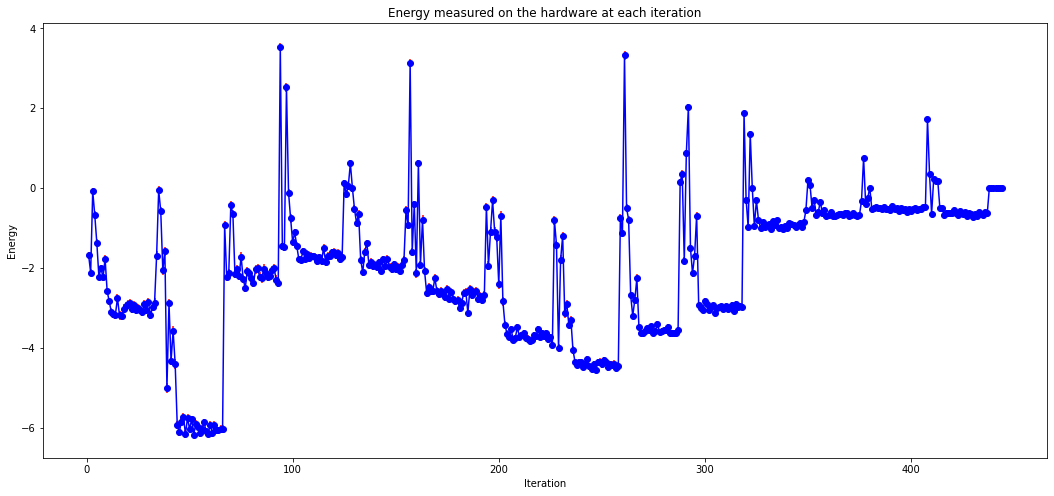

In [16]:
options = {"backend_name": "ibmq_qasm_simulator"}
runtime_inputs = {
    "operator": qubit_op,
    "offset": offset,
    "recursive": True,
    "warm_start": True,
    "optimizer": optimizer
}

job = provider.runtime.run(program_id="qaoa-RQ8n60B9Xb", options=options, inputs=runtime_inputs)

show_result(job_result=job.result())

# Real backend - IBM Oslo

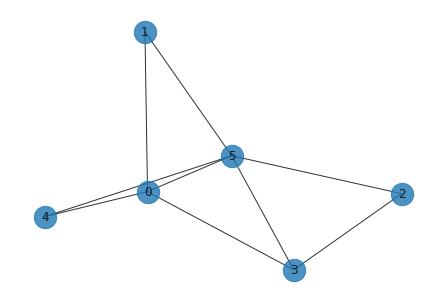

In [18]:
G = nx.Graph()

N = 5
dagree = 3

nodes = list(range(0, N+1))

edges = []
for i in range(0,N+1):
    number_of_vertices = random.randint(0,dagree)
    for k in range(0, number_of_vertices):
        j = random.randint(0,N)
        while j == i:
            j = random.randint(0,N)
        if (i, j) not in edges and (j,i) not in edges:
            edges.append((i,j))
G.add_nodes_from(nodes)
G.add_edges_from(edges)
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [19]:
max_cut = Maxcut(G)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_0*x_4 - 2*x_0*x_5 - 2*x_1*x_5 - 2*x_2*x_3
  - 2*x_2*x_5 - 2*x_3*x_5 - 2*x_4*x_5 + 4*x_0 + 2*x_1 + 2*x_2 + 3*x_3 + 2*x_4
  + 5*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



In [20]:
qubit_op, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubit_op))

Offset: -4.5
Ising Hamiltonian:
0.5 * IIIIZZ
+ 0.5 * IIZIIZ
+ 0.5 * IIZZII
+ 0.5 * IZIIIZ
+ 0.5 * ZIIIIZ
+ 0.5 * ZIIIZI
+ 0.5 * ZIIZII
+ 0.5 * ZIZIII
+ 0.5 * ZZIIII


In [21]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 7.0
variable values: x_0=0.0, x_1=1.0, x_2=1.0, x_3=1.0, x_4=1.0, x_5=0.0
status: SUCCESS


## QAOA

In [22]:
options = {"backend_name": "ibm_oslo"}
runtime_inputs = {
    "operator": qubit_op,
    "offset": offset,
    "optimizer": optimizer
}

job4 = provider.runtime.run(program_id="qaoa-RQ8n60B9Xb", options=options, inputs=runtime_inputs)

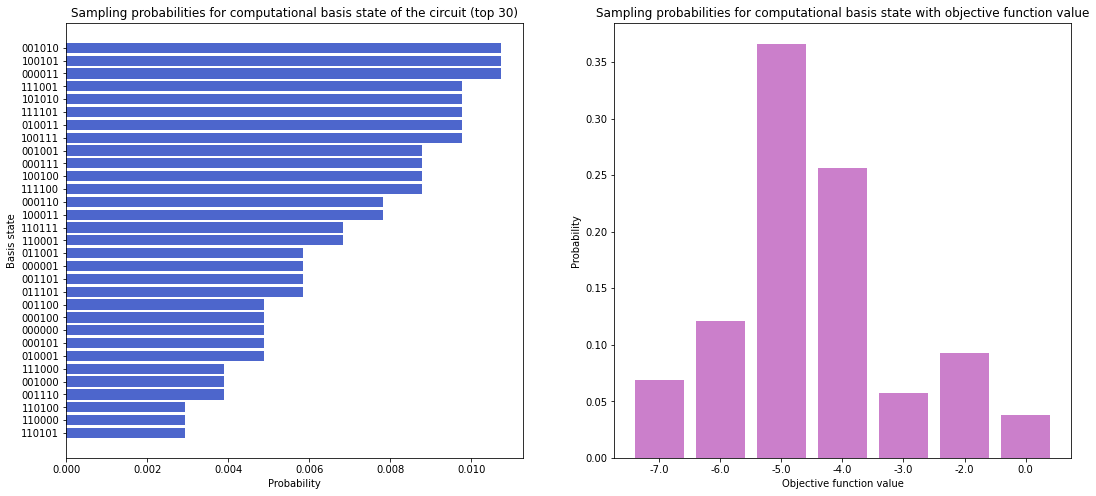

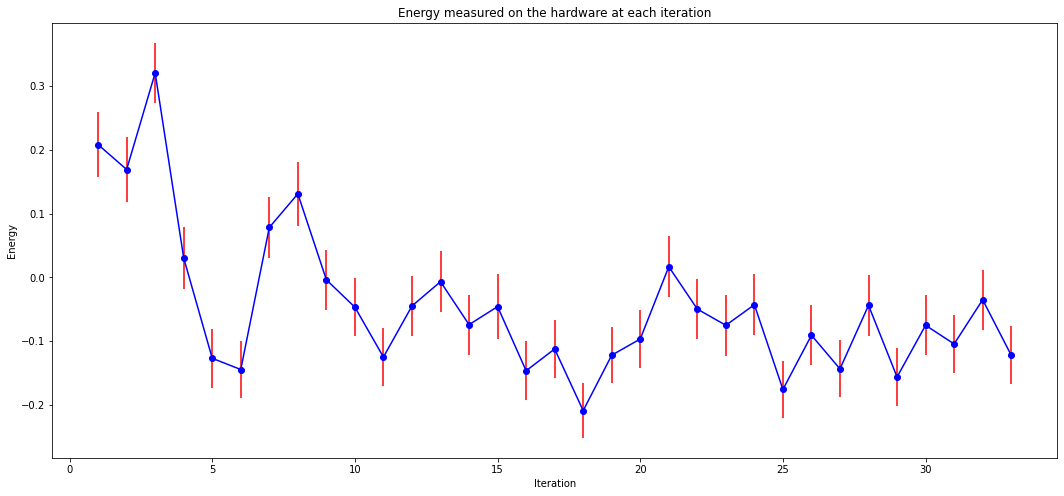

In [26]:
show_result(job_result=job4.result())

## WS-QAOA

In [23]:
options = {"backend_name": "ibm_oslo"}
runtime_inputs = {
    "operator": qubit_op,
    "offset": offset,
    "warm_start": True,
    "optimizer": optimizer
}

job1 = provider.runtime.run(program_id="qaoa-RQ8n60B9Xb", options=options, inputs=runtime_inputs)

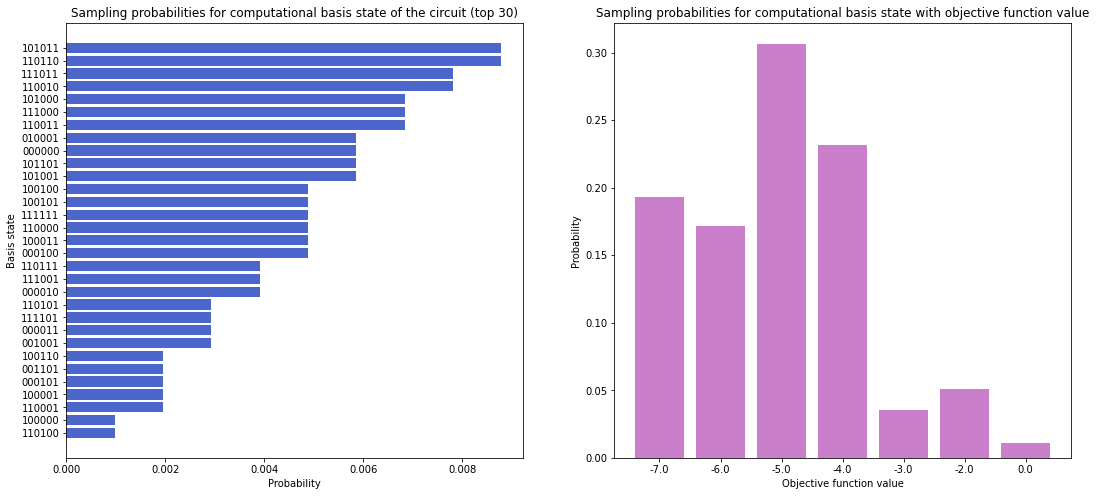

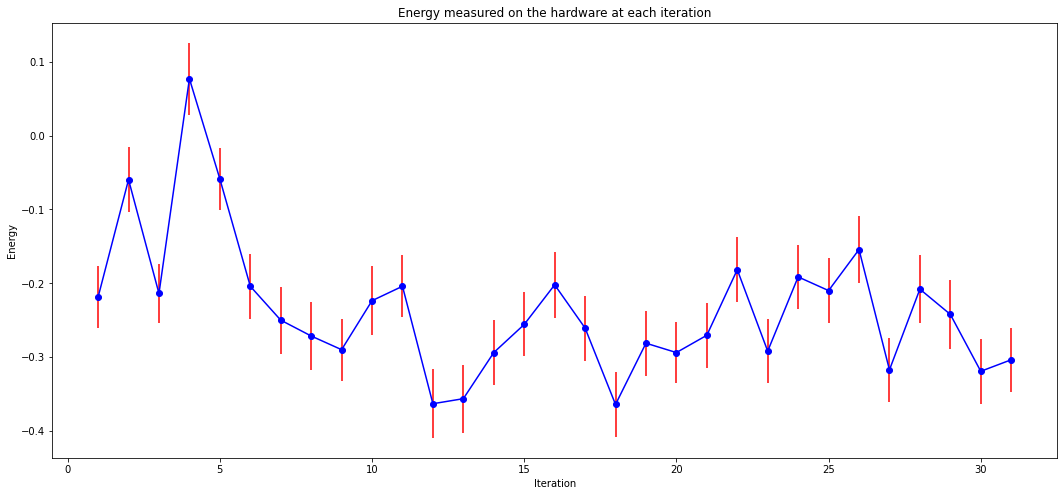

In [27]:
show_result(job_result=job1.result())

## R-QAOA

In [24]:
options = {"backend_name": "ibm_oslo"}
runtime_inputs = {
    "operator": qubit_op,
    "offset": offset,
    "recursive": True,
    "optimizer": optimizer
}

job2 = provider.runtime.run(program_id="qaoa-RQ8n60B9Xb", options=options, inputs=runtime_inputs)

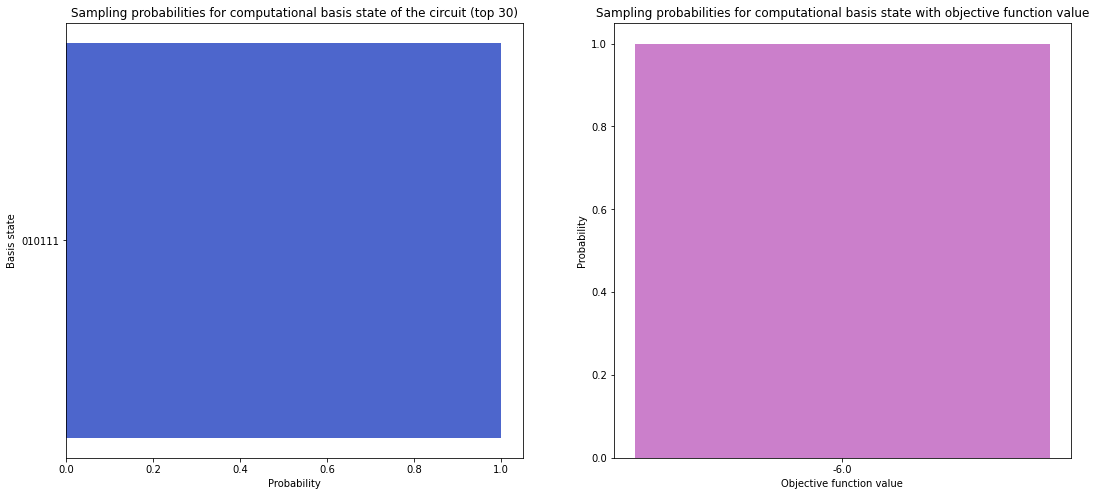

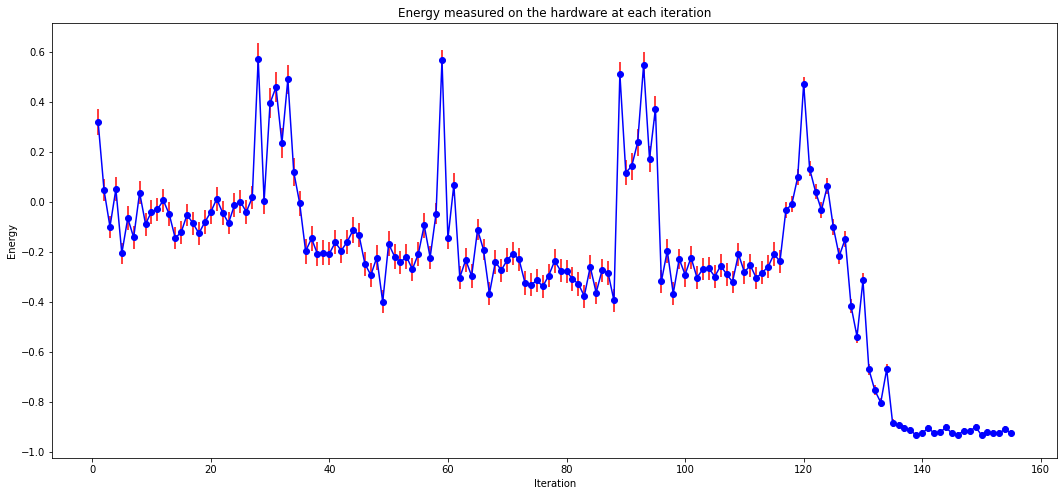

In [28]:
show_result(job_result=job2.result())

## WS-R-QAOA

In [25]:
options = {"backend_name": "ibm_oslo"}
runtime_inputs = {
    "operator": qubit_op,
    "offset": offset,
    "recursive": True,
    "warm_start": True,
    "optimizer": optimizer
}

job3 = provider.runtime.run(program_id="qaoa-RQ8n60B9Xb", options=options, inputs=runtime_inputs)

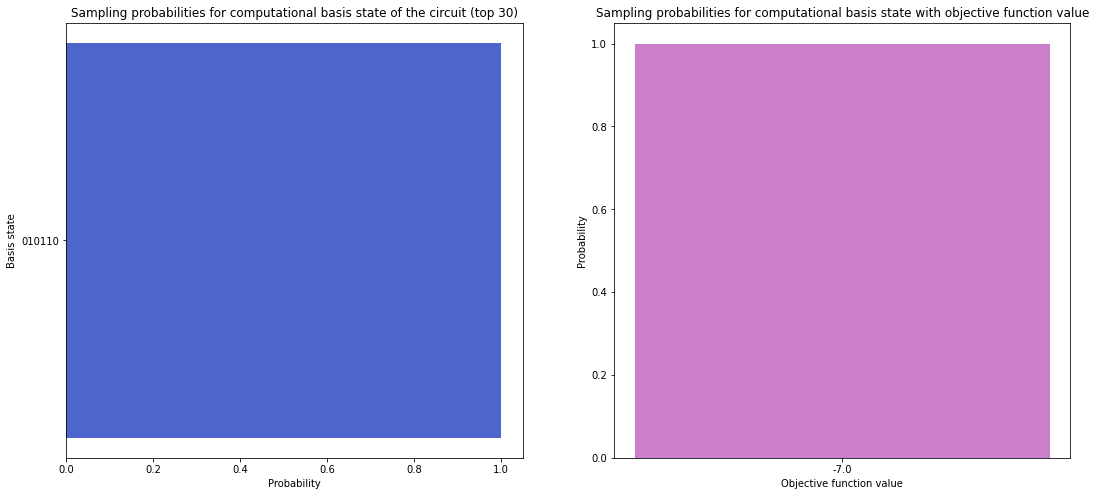

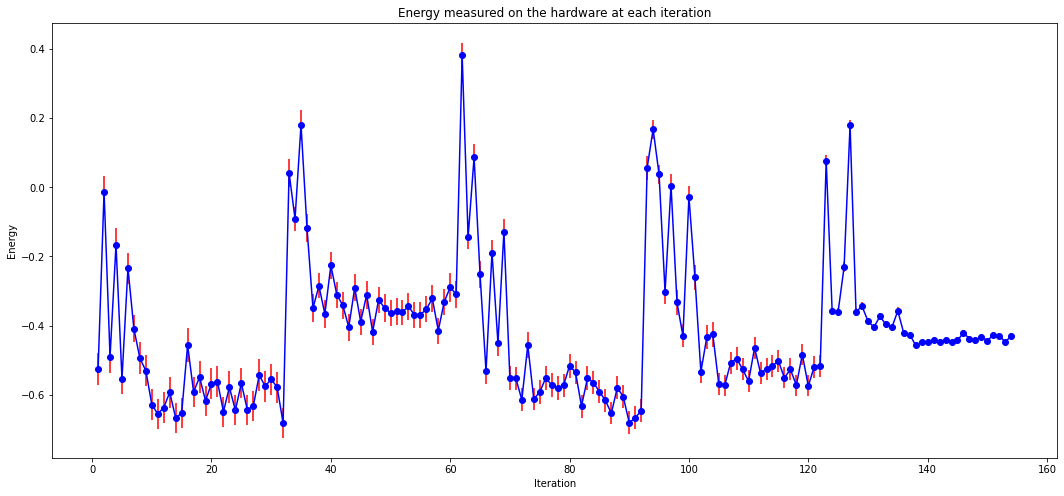

In [29]:
show_result(job_result=job3.result())